In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

TRADING_DAYS = 252
MAX_TICKERS = 12

PRESETS = {
    "Mag7": ["AAPL", "MSFT", "NVDA", "AMZN", "META", "GOOGL", "TSLA"]
}

In [2]:
from typing import List, Tuple

def parse_custom_tickers(raw: str) -> List[str]:
    parts = [p.strip().upper() for p in raw.replace(",", " ").split()]
    seen, out = set(), []
    for t in parts:
        if t and t not in seen:
            seen.add(t)
            out.append(t)
    return out

def choose_tickers(preset_name: str = "Mag7", custom_raw: str = "") -> List[str]:
    if preset_name != "Custom":
        tickers = PRESETS.get(preset_name, PRESETS["Mag7"]).copy()
    else:
        tickers = parse_custom_tickers(custom_raw)
        if not tickers:
            raise ValueError("Custom preset selected but no valid tickers.")
    if len(tickers) > MAX_TICKERS:
        print(f"[WARN] Provided {len(tickers)}; capping to {MAX_TICKERS}.")
        tickers = tickers[:MAX_TICKERS]
    return tickers

In [3]:
def fetch_prices(tickers: List[str], start: str, end: str) -> pd.DataFrame:
    raw = yf.download(tickers, start=start, end=end,
                      auto_adjust=True, progress=False)

    if isinstance(raw.columns, pd.MultiIndex):
        prices = raw["Close"].copy()
    else:
        prices = raw["Close"].to_frame()
        prices.columns = [tickers[0]]

    prices = prices.dropna(how="any")
    if prices.shape[0] == 0:
        raise ValueError("No overlapping history after NA drop.")
    return prices

In [4]:
def compute_log_returns(prices: pd.DataFrame) -> pd.DataFrame:
    return np.log(prices / prices.shift(1)).dropna()

def estimate_params(log_rets: pd.DataFrame) -> Tuple[pd.Series, pd.DataFrame]:
    mu_daily = log_rets.mean()
    cov_daily = log_rets.cov()
    return mu_daily, cov_daily

In [5]:
def simulate_portfolio_returns(
    mu_daily: pd.Series,
    cov_daily: pd.DataFrame,
    weights: np.ndarray,
    horizon_days: int = 1,
    sims: int = 10_000,
    seed: int = 42
) -> np.ndarray:
    np.random.seed(seed)
    mu_h = mu_daily.values * horizon_days
    cov_h = cov_daily.values * horizon_days

    draws = np.random.multivariate_normal(mean=mu_h, cov=cov_h, size=sims)
    port_log_rets = draws @ weights
    port_rets = np.exp(port_log_rets) - 1.0
    return port_rets

In [6]:
def var_es_from_returns(port_rets: np.ndarray, alpha: float = 0.95):
    losses = -port_rets
    var_level = 100 * alpha
    var = np.percentile(losses, var_level)
    tail_losses = losses[losses >= var]
    es = tail_losses.mean() if tail_losses.size > 0 else var
    return float(var), float(es)

def plot_loss_distribution(port_rets: np.ndarray, var: float, es: float,
                           alpha: float, title: str = ""):
    losses = -port_rets
    plt.figure(figsize=(8, 5))
    plt.hist(losses, bins=60)
    plt.axvline(var, linestyle="--", label=f"VaR {int(alpha*100)}% = {var:.4f}")
    plt.axvline(es, linestyle=":", label=f"ES {int(alpha*100)}% = {es:.4f}")
    plt.xlabel("Loss (positive = loss)")
    plt.ylabel("Frequency")
    if not title:
        title = f"Loss Distribution (alpha={alpha:.2f})"
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

Using tickers: ['AAPL', 'MSFT', 'NVDA', 'AMZN', 'META', 'GOOGL', 'TSLA']

== Risk Summary ==
Horizon: 1 day(s)
Confidence: 95%
VaR (loss): 0.0321
ES  (loss): 0.0402
Mean return: 0.0015
Min  return: -0.0787
Max  return: 0.0876


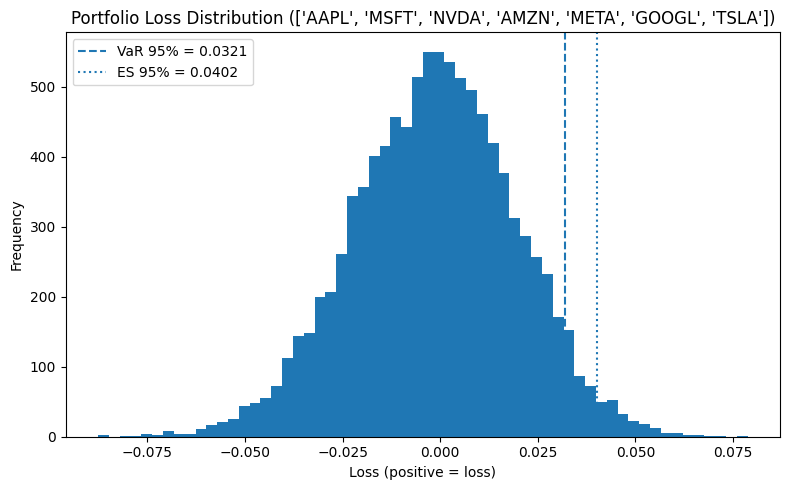

In [7]:
# Parameters for this notebook run
preset_name = "Mag7"          # or "Custom"
custom_raw = ""               # e.g. "SOFI, OPEN, VOO" if preset_name=="Custom"
start = "2020-01-01"
end = "2025-01-01"
horizon_days = 1
sims = 10_000
alpha = 0.95

tickers = choose_tickers(preset_name, custom_raw)
print("Using tickers:", tickers)

prices = fetch_prices(tickers, start, end)
log_rets = compute_log_returns(prices)
mu_daily, cov_daily = estimate_params(log_rets)

n = len(tickers)
weights = np.full(n, 1.0 / n)  # equal-weight

port_rets = simulate_portfolio_returns(mu_daily, cov_daily, weights,
                                       horizon_days=horizon_days,
                                       sims=sims)

var, es = var_es_from_returns(port_rets, alpha=alpha)

print("\n== Risk Summary ==")
print(f"Horizon: {horizon_days} day(s)")
print(f"Confidence: {int(alpha*100)}%")
print(f"VaR (loss): {var:.4f}")
print(f"ES  (loss): {es:.4f}")
print(f"Mean return: {port_rets.mean():.4f}")
print(f"Min  return: {port_rets.min():.4f}")
print(f"Max  return: {port_rets.max():.4f}")

plot_loss_distribution(port_rets, var, es, alpha,
                       title=f"Portfolio Loss Distribution ({tickers})")